In [49]:
""" This notebook analyses the chances of a student to be accepted to graduate school. The data 
set considers factors such as cummulative GPA, TOEFL score, GRE score and university reputation.  
The dataset is analysed using a simple Random Forest model tuned with randomized search 
crossvalidation in order to improve performance. The random forest was chosen because it 
required the least amount of data preprocessing to obtain good results, but other algorithms 
such as  Linear Regression, Logistic Regression, K-Nearest Neighbours can be used equally well."""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [8]:
df = pd.read_csv("admissions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.2 KB


In [9]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [10]:
df = df.drop(['Serial No.'],axis=1) 

In [13]:
#check if there are any missing values in the dataset (NaN or None values)
df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

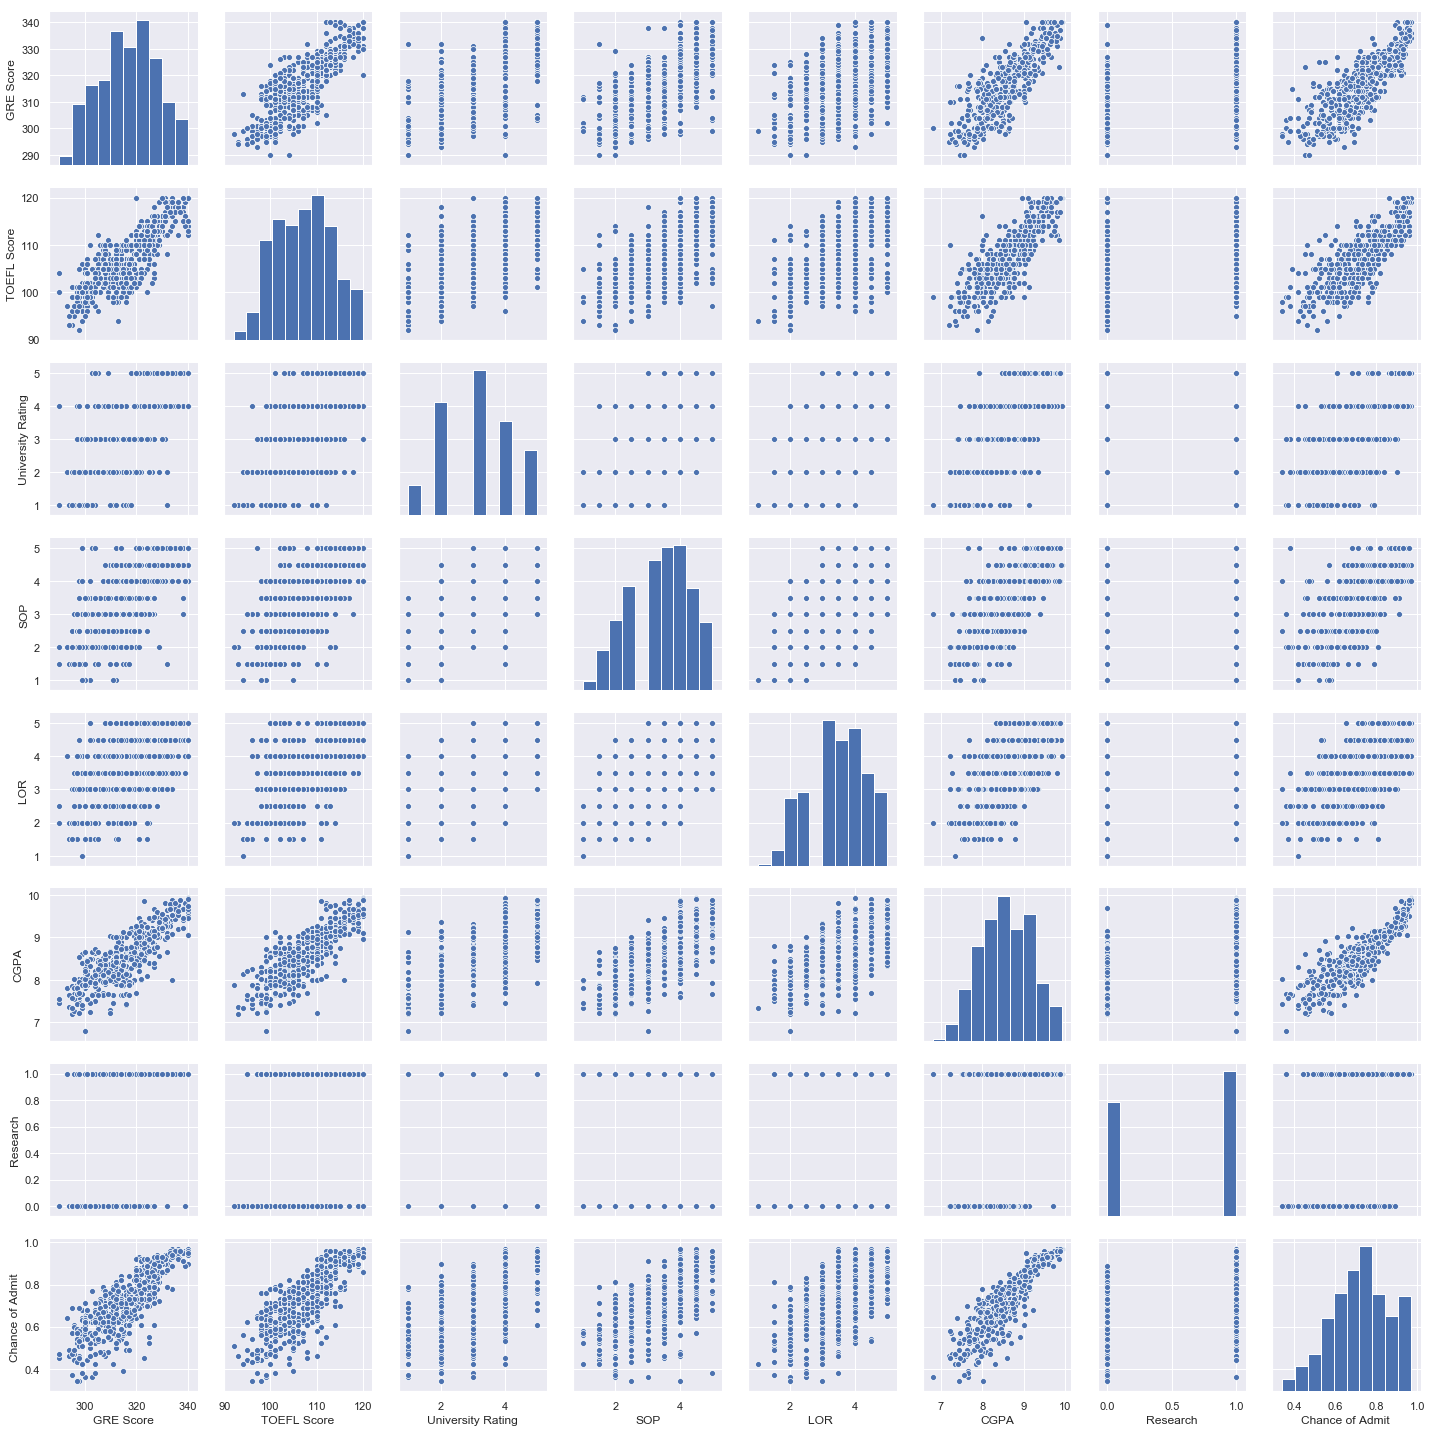

In [14]:
# Most features follow a normal distribution as expected (GRE score, TOEFL score, university rating, GPA)
# The chance of admission is slightly skewed toward the right tail (almost all students have some reasonable chance 
# of being admittted, but there are fewer who have a higher chance of being admitted at prestigious universities.)

sns.pairplot(df)

In [17]:
toefl_score = df['TOEFL Score'];
gre_score = df['GRE Score'];
university_rating = df['University Rating']
cgpa = df['CGPA']
research = df['Research']
chance_of_admit = df[df.columns[-1]];

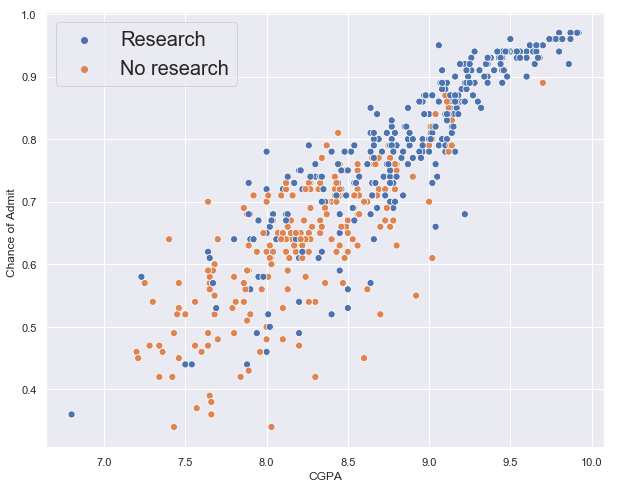

In [18]:
# A simple scatter plot of the chance of admission against the GPA. 
# It seems that the higher the GPA leads to higher the chances of admission. 
# Students who have a high GPA are more likely to have carried out research.

plt_colours = ["cornflowerblue","lightsalmon"]
colours = [plt_colours[0] if research[i] else plt_colours[1] for i in range(research.size)]
research_array = np.asarray(['Research' if research[i] else 'No research' for i in range(research.size)])



plt.figure(figsize=(10,8))
sns.scatterplot(cgpa,chance_of_admit,c=colours,s=50,hue=research_array)
plt.legend(fontsize=20)
plt.show()

//anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


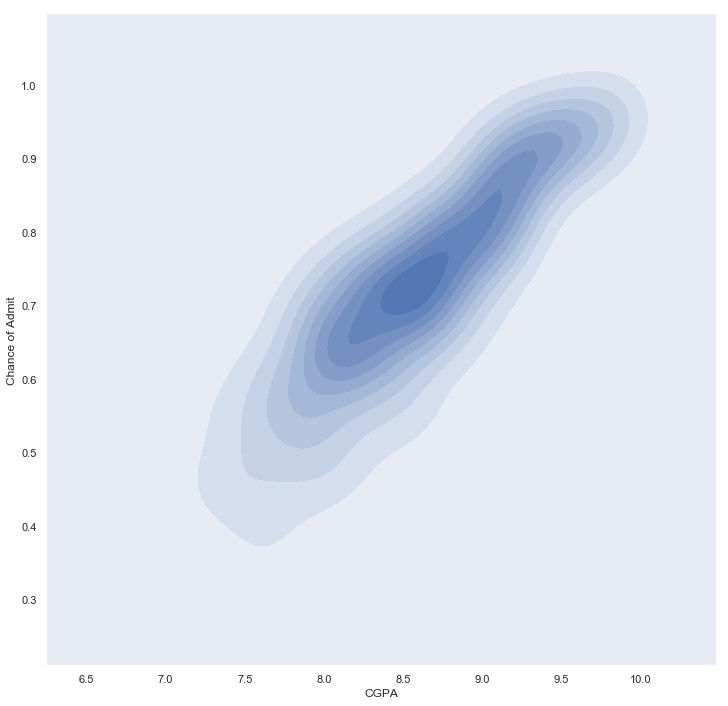

In [19]:
# A kernel density plot of the chance of admission against the GPA

plt.figure(figsize=(12,12))
g = sns.kdeplot(cgpa, chance_of_admit,shade=True)

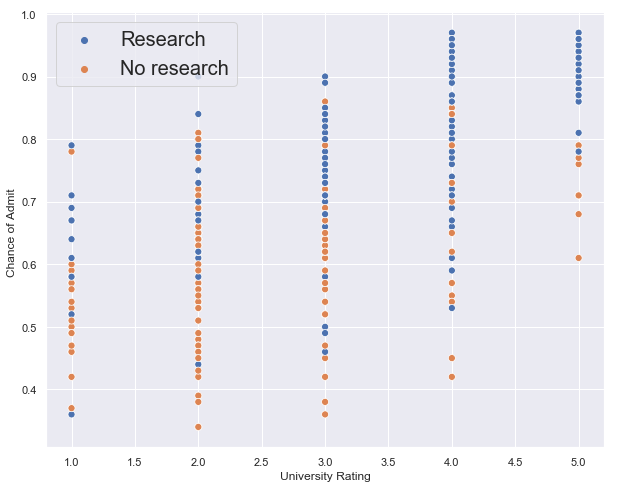

In [20]:
# Unsurprisingly, the students admitted to better universities

plt.figure(figsize=(10,8))
sns.scatterplot(university_rating,chance_of_admit,c=colours,s=50,hue=research_array)
plt.legend(fontsize=20)
plt.show()

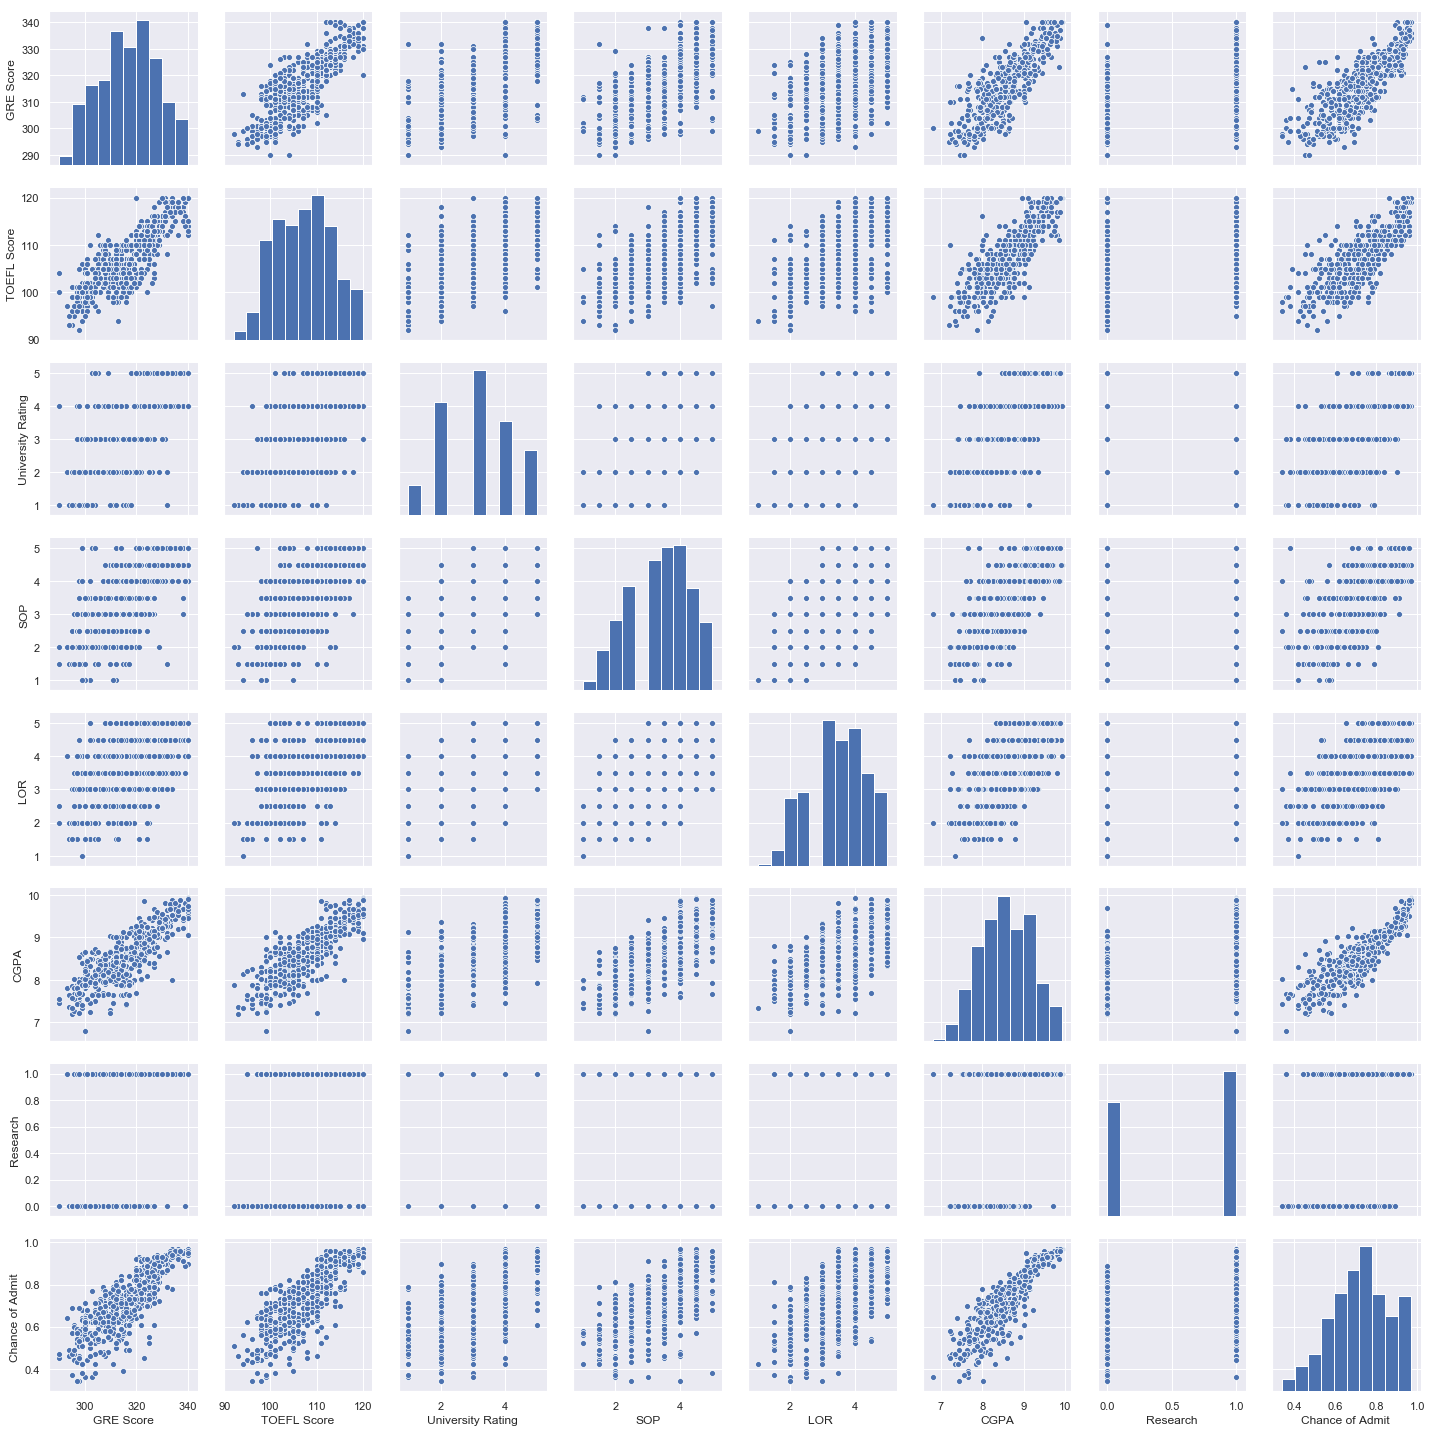

In [21]:
# Most features follow a normal distribution as expected (GRE score, TOEFL score, university rating, GPA)
# The chance of admission is slightly skewed toward the right tail (almost all students have some reasonable chance 
# of being admittted, but there are fewer who have a higher chance of being admitted at prestigious universities.)

sns.pairplot(df)

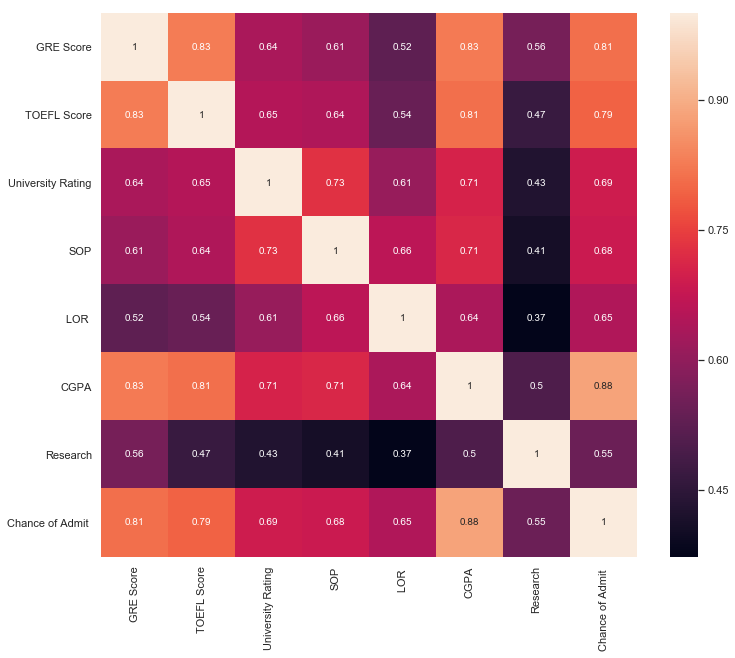

In [22]:
# The correlation plot show a high correlation between most features. That is to be expected as stronger students will
# generally test better across different exams (TOEFL, GRE) and they will also achieve a higher GPA. Interestingly,
# research has the least correlation with the chance of being admitted. 
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True)


In [23]:
y = chance_of_admit 
X = df.drop(['Chance of Admit '],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=400)
rf.fit(X,y)
print(rf.score)


<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)>


In [12]:
y_pred = rf.predict(X_test)

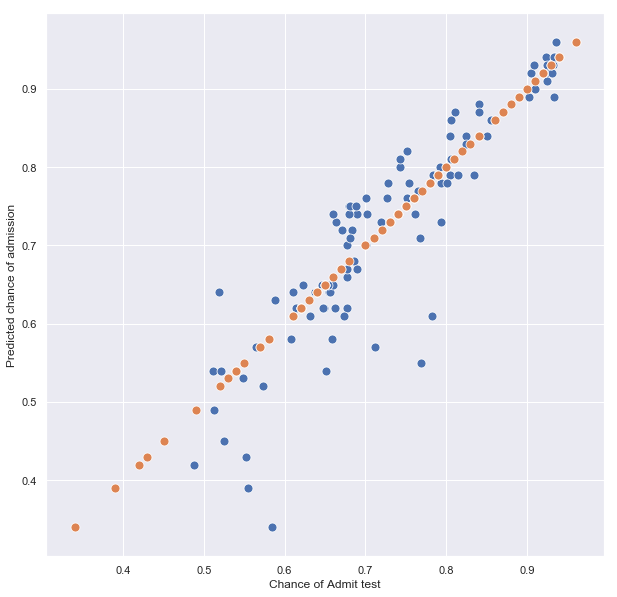

In [13]:
# Initial simple model for random forest with default parameters

plt.figure(figsize=(10,10))
sns.scatterplot(y_pred,y_test,s=80)
sns.scatterplot(y_test,y_test,s=80)
plt.xlabel("Chance of Admit test")
plt.ylabel("Predicted chance of admission")

In [51]:
# The parameters of the random forest are improved via a random search of the parameter space 
# with crossvalidation.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



# A random grid will be used to tune the model's hyper parameters with three folds for crossvalidation
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
rf_random.fit(X, y)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [15]:
# Get the best parameters from the randomized search
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [16]:
print(rf_random.best_estimator_.feature_importances_)

[0.23329166 0.17827362 0.07482889 0.07975514 0.04258926 0.36297823
 0.0282832 ]


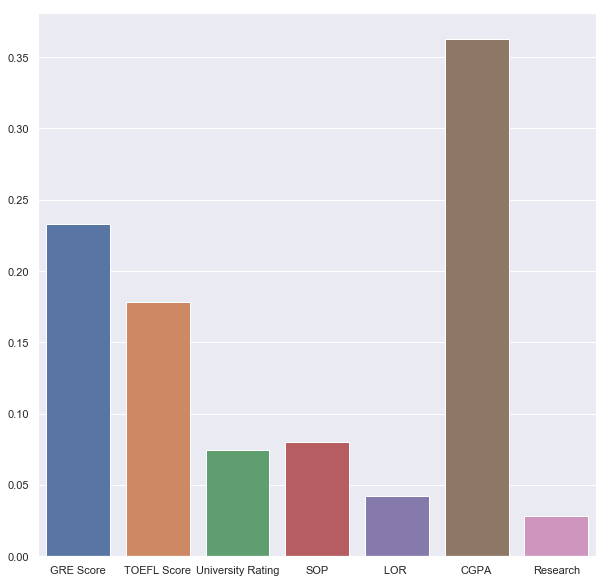

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x=X.columns, y=rf_random.best_estimator_.feature_importances_)


In [18]:
'''It does seem that the cummulative GPA is the most important factor by far in the university admissions.
The data set is highly multicollinear, as strong students tend to achieve a high GPA as well as high GRE and TOEFL scores.
It seems that the statement of purpose and letters of reccomandation are generally not very important. Research showed
the least correlation, however the majority of the better students had carried out research as well. 
It seems that the best strategy for getting into a strong graduate program would be to focus primarily on GPA
and then on TOEFL and GRE. Interestingly, the university ranking is not very important so candidates should not be
intimidated to apply to higher rated universities.'''

In [ ]:
'''Potential improvements: Using higher complexity algorithms, boosted trees (XGBoost, LightGBM)
Investigate how to deal with high multicollinearity, maybe use PCA for dimensionality reduction. 

A few notes about the data set: this is collected only for students from an Engineering background so there is some
heavy selection bias in the data. It is not clear to me how the probability of admission is inferred initially. The
strength of the LOR, and .

Finally, to get into a good grad school, a candidate should maximise  '''

In [65]:
y = chance_of_admit 
X = df.drop(['Chance of Admit '],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=400)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred1 = rf.predict(X)
mean_squared_error(y_pred,y_test)

0.004491937450665327

In [66]:
lr =  LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred2 = lr.predict(X)
mean_squared_error(y_pred,y_test)

0.0034590988971363824

In [67]:
nn = KNeighborsRegressor()
nn.fit(X_train,y_train)
y_pred = nn.predict(X_test)
y_pred3 = nn.predict(X)
mean_squared_error(y_pred,y_test)

0.005351159999999998

In [71]:
X = pd.DataFrame({'lr':y_pred2,'nn':y_pred3,'rf':y_pred1})
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
stacked = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=400)
stacked.fit(X_train,y_train)
y_pred = stacked.predict(X_test)
mean_squared_error(y_pred,y_test)

(500, 3)
(500,)


0.004189520998262626